In [1]:
import rvnewop as rv

from glob import glob
from itertools import accumulate
import json

import matplotlib.pyplot as plt

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.readwrite import json_graph

Processing ./embench_hst/matmult-int.hst...
instruction #0


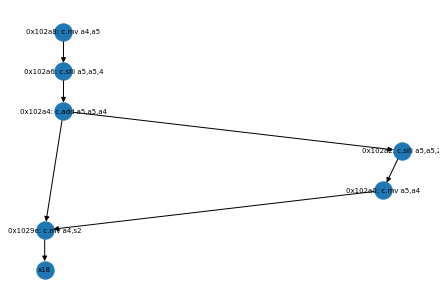

{"directed": true, "multigraph": false, "graph": [["sub_block", "B108.0"]], "nodes": [{"type": "register", "id": "x18"}, {"type": "instruction", "pc": 66206, "id": "0x1029e: c.mv a4,s2"}, {"type": "instruction", "pc": 66208, "id": "0x102a0: c.mv a5,a4"}, {"type": "instruction", "pc": 66210, "id": "0x102a2: c.slli a5,a5,2"}, {"type": "instruction", "pc": 66212, "id": "0x102a4: c.add a5,a5,a4"}, {"type": "instruction", "pc": 66214, "id": "0x102a6: c.slli a5,a5,4"}, {"type": "instruction", "pc": 66216, "id": "0x102a8: c.mv a4,a5"}], "adjacency": [[], [{"id": "x18"}], [{"id": "0x1029e: c.mv a4,s2"}], [{"id": "0x102a0: c.mv a5,a4"}], [{"id": "0x102a2: c.slli a5,a5,2"}, {"id": "0x1029e: c.mv a4,s2"}], [{"id": "0x102a4: c.add a5,a5,a4"}], [{"id": "0x102a6: c.slli a5,a5,4"}]]}
instruction #1


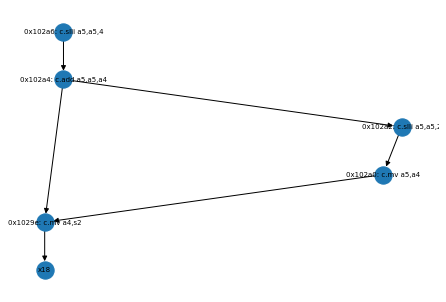

{"directed": true, "multigraph": false, "graph": [["sub_block", "B108.0"]], "nodes": [{"type": "register", "id": "x18"}, {"type": "instruction", "pc": 66206, "id": "0x1029e: c.mv a4,s2"}, {"type": "instruction", "pc": 66208, "id": "0x102a0: c.mv a5,a4"}, {"type": "instruction", "pc": 66210, "id": "0x102a2: c.slli a5,a5,2"}, {"type": "instruction", "pc": 66212, "id": "0x102a4: c.add a5,a5,a4"}, {"type": "instruction", "pc": 66214, "id": "0x102a6: c.slli a5,a5,4"}], "adjacency": [[], [{"id": "x18"}], [{"id": "0x1029e: c.mv a4,s2"}], [{"id": "0x102a0: c.mv a5,a4"}], [{"id": "0x102a2: c.slli a5,a5,2"}, {"id": "0x1029e: c.mv a4,s2"}], [{"id": "0x102a4: c.add a5,a5,a4"}]]}
instruction #2


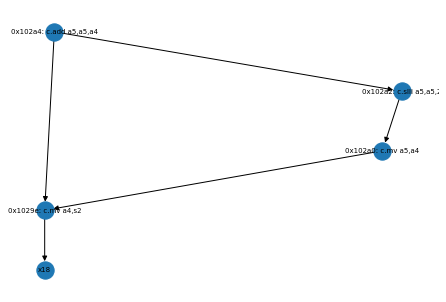

{"directed": true, "multigraph": false, "graph": [["sub_block", "B108.0"]], "nodes": [{"type": "register", "id": "x18"}, {"type": "instruction", "pc": 66206, "id": "0x1029e: c.mv a4,s2"}, {"type": "instruction", "pc": 66208, "id": "0x102a0: c.mv a5,a4"}, {"type": "instruction", "pc": 66210, "id": "0x102a2: c.slli a5,a5,2"}, {"type": "instruction", "pc": 66212, "id": "0x102a4: c.add a5,a5,a4"}], "adjacency": [[], [{"id": "x18"}], [{"id": "0x1029e: c.mv a4,s2"}], [{"id": "0x102a0: c.mv a5,a4"}], [{"id": "0x102a2: c.slli a5,a5,2"}, {"id": "0x1029e: c.mv a4,s2"}]]}
instruction #3


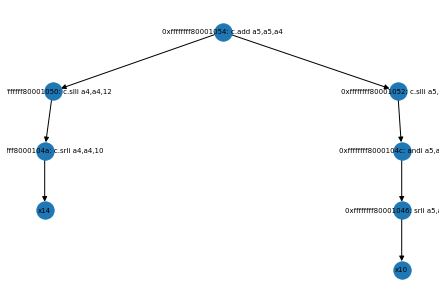

{"directed": true, "multigraph": false, "graph": [["sub_block", "B354.0"]], "nodes": [{"type": "register", "id": "x10"}, {"type": "register", "id": "x14"}, {"type": "instruction", "pc": 18446744071562072134, "id": "0xffffffff80001046: srli a5,a0,12"}, {"type": "instruction", "pc": 18446744071562072138, "id": "0xffffffff8000104a: c.srli a4,a4,10"}, {"type": "instruction", "pc": 18446744071562072140, "id": "0xffffffff8000104c: andi a5,a5,1023"}, {"type": "instruction", "pc": 18446744071562072144, "id": "0xffffffff80001050: c.slli a4,a4,12"}, {"type": "instruction", "pc": 18446744071562072146, "id": "0xffffffff80001052: c.slli a5,a5,2"}, {"type": "instruction", "pc": 18446744071562072148, "id": "0xffffffff80001054: c.add a5,a5,a4"}], "adjacency": [[], [], [{"id": "x10"}], [{"id": "x14"}], [{"id": "0xffffffff80001046: srli a5,a0,12"}], [{"id": "0xffffffff8000104a: c.srli a4,a4,10"}], [{"id": "0xffffffff8000104c: andi a5,a5,1023"}], [{"id": "0xffffffff80001052: c.slli a5,a5,2"}, {"id": "0xf

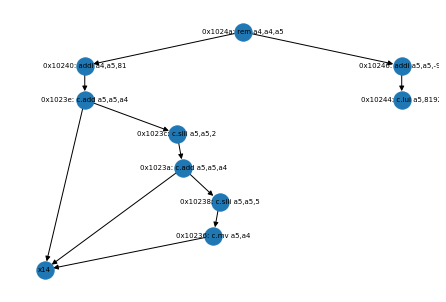

{"directed": true, "multigraph": false, "graph": [["sub_block", "B83.4"]], "nodes": [{"type": "register", "id": "x14"}, {"type": "instruction", "pc": 66102, "id": "0x10236: c.mv a5,a4"}, {"type": "instruction", "pc": 66104, "id": "0x10238: c.slli a5,a5,5"}, {"type": "instruction", "pc": 66106, "id": "0x1023a: c.add a5,a5,a4"}, {"type": "instruction", "pc": 66108, "id": "0x1023c: c.slli a5,a5,2"}, {"type": "instruction", "pc": 66110, "id": "0x1023e: c.add a5,a5,a4"}, {"type": "instruction", "pc": 66112, "id": "0x10240: addi a4,a5,81"}, {"type": "instruction", "pc": 66116, "id": "0x10244: c.lui a5,8192"}, {"type": "instruction", "pc": 66118, "id": "0x10246: addi a5,a5,-97"}, {"type": "instruction", "pc": 66122, "id": "0x1024a: rem a4,a4,a5"}], "adjacency": [[], [{"id": "x14"}], [{"id": "0x10236: c.mv a5,a4"}], [{"id": "0x10238: c.slli a5,a5,5"}, {"id": "x14"}], [{"id": "0x1023a: c.add a5,a5,a4"}], [{"id": "0x1023c: c.slli a5,a5,2"}, {"id": "x14"}], [{"id": "0x1023e: c.add a5,a5,a4"}], []

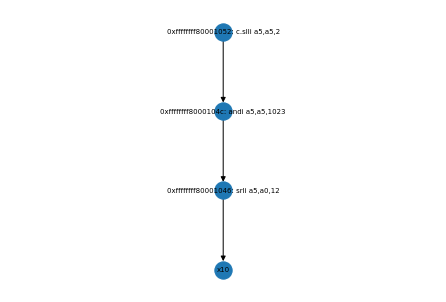

{"directed": true, "multigraph": false, "graph": [["sub_block", "B354.0"]], "nodes": [{"type": "register", "id": "x10"}, {"type": "instruction", "pc": 18446744071562072134, "id": "0xffffffff80001046: srli a5,a0,12"}, {"type": "instruction", "pc": 18446744071562072140, "id": "0xffffffff8000104c: andi a5,a5,1023"}, {"type": "instruction", "pc": 18446744071562072146, "id": "0xffffffff80001052: c.slli a5,a5,2"}], "adjacency": [[], [{"id": "x10"}], [{"id": "0xffffffff80001046: srli a5,a0,12"}], [{"id": "0xffffffff8000104c: andi a5,a5,1023"}]]}
instruction #6


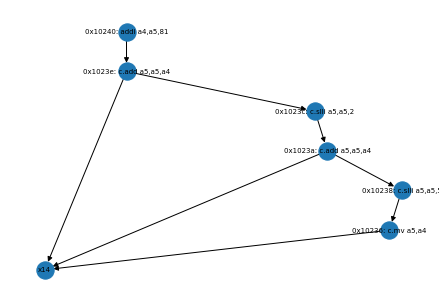

{"directed": true, "multigraph": false, "graph": [["sub_block", "B83.4"]], "nodes": [{"type": "register", "id": "x14"}, {"type": "instruction", "pc": 66102, "id": "0x10236: c.mv a5,a4"}, {"type": "instruction", "pc": 66104, "id": "0x10238: c.slli a5,a5,5"}, {"type": "instruction", "pc": 66106, "id": "0x1023a: c.add a5,a5,a4"}, {"type": "instruction", "pc": 66108, "id": "0x1023c: c.slli a5,a5,2"}, {"type": "instruction", "pc": 66110, "id": "0x1023e: c.add a5,a5,a4"}, {"type": "instruction", "pc": 66112, "id": "0x10240: addi a4,a5,81"}], "adjacency": [[], [{"id": "x14"}], [{"id": "0x10236: c.mv a5,a4"}], [{"id": "0x10238: c.slli a5,a5,5"}, {"id": "x14"}], [{"id": "0x1023a: c.add a5,a5,a4"}], [{"id": "0x1023c: c.slli a5,a5,2"}, {"id": "x14"}], [{"id": "0x1023e: c.add a5,a5,a4"}]]}
instruction #7


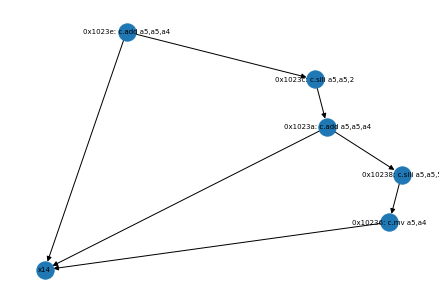

{"directed": true, "multigraph": false, "graph": [["sub_block", "B83.4"]], "nodes": [{"type": "register", "id": "x14"}, {"type": "instruction", "pc": 66102, "id": "0x10236: c.mv a5,a4"}, {"type": "instruction", "pc": 66104, "id": "0x10238: c.slli a5,a5,5"}, {"type": "instruction", "pc": 66106, "id": "0x1023a: c.add a5,a5,a4"}, {"type": "instruction", "pc": 66108, "id": "0x1023c: c.slli a5,a5,2"}, {"type": "instruction", "pc": 66110, "id": "0x1023e: c.add a5,a5,a4"}], "adjacency": [[], [{"id": "x14"}], [{"id": "0x10236: c.mv a5,a4"}], [{"id": "0x10238: c.slli a5,a5,5"}, {"id": "x14"}], [{"id": "0x1023a: c.add a5,a5,a4"}], [{"id": "0x1023c: c.slli a5,a5,2"}, {"id": "x14"}]]}
instruction #8


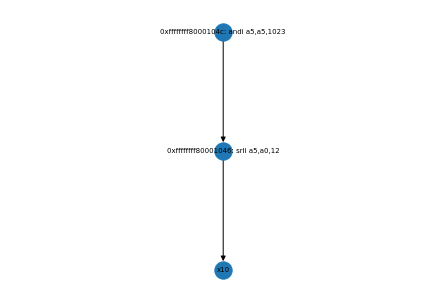

{"directed": true, "multigraph": false, "graph": [["sub_block", "B354.0"]], "nodes": [{"type": "register", "id": "x10"}, {"type": "instruction", "pc": 18446744071562072140, "id": "0xffffffff8000104c: andi a5,a5,1023"}, {"type": "instruction", "pc": 18446744071562072134, "id": "0xffffffff80001046: srli a5,a0,12"}], "adjacency": [[], [{"id": "0xffffffff80001046: srli a5,a0,12"}], [{"id": "x10"}]]}
instruction #9


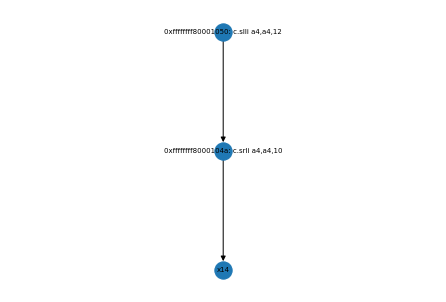

{"directed": true, "multigraph": false, "graph": [["sub_block", "B354.0"]], "nodes": [{"type": "instruction", "pc": 18446744071562072138, "id": "0xffffffff8000104a: c.srli a4,a4,10"}, {"type": "register", "id": "x14"}, {"type": "instruction", "pc": 18446744071562072144, "id": "0xffffffff80001050: c.slli a4,a4,12"}], "adjacency": [[{"id": "x14"}], [], [{"id": "0xffffffff8000104a: c.srli a4,a4,10"}]]}
Saved 18339450 cycles out of 19196666 (95.53%) with 126 new instructions
max depth: 6
max mult depth: 7


In [2]:
%matplotlib inline
FILENAME = "./embench_hst/matmult-int.hst"
print("Processing {}...".format(FILENAME))

prog = rv.Histogram.parse(FILENAME, isa="32ICM")
prog.findBasicBlocks()

prog.addLivenessValuesToGraph()

# total cycles = sum of all the frequencies
total_cycles = sum(
    [inst.freq for bb in prog.basicBlocks for inst in bb.bbInstructions()]
)

new_instructions = []

for i, b in enumerate((prog.getSubBlocks())):
    graph = b.constructDAG()

    # temp will store every permutation of candidate subgraphs
    temp = []
    for n in rv.analysis.findCandidateSubgraphs(prog, graph):
        subtree = rv.analysis.createSubtreeFromNode(graph, n)
        root = n

        temp.append(rv.Subgraph(subtree, root))

    # add candidate subgraph with highest score to new instructions list
    current_nodes = set()
    temp = sorted(temp, key=lambda sg: sg.score, reverse=True)
    while temp:
        if any([(n in current_nodes) for n in temp[0].graph.nodes]):
            temp.pop(0)
        else:
            new_instructions.append(temp.pop(0))

new_instructions = sorted(new_instructions, key=lambda sg: sg.score, reverse=True)

inst_dict = {}
for subgraph in new_instructions:
    key = rv.analysis.graphToParenString(subgraph.graph)

    if key in inst_dict:
        inst_dict[key].score += subgraph.score
    else:
        inst_dict[key] = subgraph

new_instructions = [inst_dict[key] for key in inst_dict]

max_depth = 0
max_mult_depth = 0
for sg in new_instructions:
    if sg.containsMultiplyInstruction():
        max_mult_depth = max(max_mult_depth, sg.depth)
    else:
        max_depth = max(max_depth, sg.depth)

saved_cycles = sum([sg.score for sg in new_instructions])
percent_cycles = float(saved_cycles) / total_cycles * 100
#plt.clf()
#plt.plot([x for x in range(len(new_instructions))],list(map(lambda x:x/total_cycles, accumulate([sg.score for sg in new_instructions]))))
#plt.show()


#from matplotlib.pyplot import figure
#figure(num=None, figsize=(12,8), dpi=80, facecolor='w', edgecolor='k')

i = 0
for sg in new_instructions[:10]:
    print("instruction #{}".format(i))
    plt.clf()
    pos = graphviz_layout(sg.graph, prog="dot")
    nx.draw(sg.graph, pos, with_labels=True, font_size=7)
    
    plt.show()
    i+=1
    
    # print out JSON
    for n in sg.graph:
        if sg.graph.nodes[n]['type'] == "instruction":
            try:
                del sg.graph.nodes[n]['instruction']
            except:
                pass
    
    data = json_graph.adjacency_data(sg.graph)
    print(json.dumps(data))

print(
    """Saved {} cycles out of {} ({:.4}%) with {} new instructions""".format(
        saved_cycles, total_cycles, percent_cycles, len(new_instructions)
    )
)
print("max depth: {}\nmax mult depth: {}".format(max_depth, max_mult_depth))
